#UMADock from CafChem tools. Docks a ligand from a SMILES string into a pre-defined protein binding site (Take from the DuDE structures) and calculates electroninc binding energy with Meta's UMA MLIP.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MauricioCafiero/UMADock/blob/main/notebooks/UMA_Dock.ipynb)

## This notebook allows you to:
- Input a smiles string and generate a set number of conformers.
- Dock the conformers in one of several available protein binding sites (DRD2, HMGCR, MAOB, ADRB2)
- Optimize the best pose from each conformer and
- Calculate the electronic binding energy with the UMA MLIP (including ligand desolvation and strain energy).
- visualize the best pose.
- perform rudimentary dynamics on the best pose

## Requirements:
- This notebook will install several py3Dmol, Fairchem-core and rdkit.
- Runs well on an L4 GPU; will run faster on an A100.

## Set-up

### Install libraries

In [1]:
!pip install -q fairchem-core
!pip install -q py3Dmol
!pip install -q rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.8/304.8 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 449.9/449.9 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.0/303.0 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 119.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.6/766.6 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66

### Get CafChem from Github, import libraries, download UMA

In [2]:
!git clone https://github.com/MauricioCafiero/CafChem.git

!git clone https://github.com/MauricioCafiero/UMADock.git

Cloning into 'CafChem'...
remote: Enumerating objects: 924, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 924 (delta 157), reused 58 (delta 58), pack-reused 721 (from 3)
Receiving objects: 100% (924/924), 45.14 MiB | 17.12 MiB/s, done.
Resolving deltas: 100% (531/531), done.
Cloning into 'UMADock'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 94 (delta 49), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (94/94), 10.50 MiB | 9.18 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [3]:
import py3Dmol
import os
import torch
from google.colab import files
import numpy as np
from fairchem.core import FAIRChemCalculator, pretrained_mlip

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

import UMADock.UMADock as ud

/content/UMADock/UMADock.py:1141: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_table(log_file, sep="\s+")


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

predictor = pretrained_mlip.get_predict_unit("uma-s-1", device=device)
calculator = FAIRChemCalculator(predictor, task_name="omol")
model = "UMA-OMOL"

checkpoints/uma-s-1.pt:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

iso_atom_elem_refs.yaml:   0%|          | 0.00/9.00k [00:00<?, ?B/s]

## UMA Dock

In [5]:
test_confs = ud.conformers("O=C(O)[C@@](NN)(Cc1cc(O)c(O)cc1)C",20)
em_mols = test_confs.get_confs(use_random=True)
ex_mols = test_confs.expand_conf()
xyz_strings = test_confs.get_XYZ_strings()
confs = test_confs.prep_XYZ_docking()

In [6]:
ldopa_dock = ud.UMA_Dock(confs, 20, calculator, ud.DRD2_data)

There are 1 molecules with size: 216
for 2, 218


In [7]:
new_molecules, ies, distances = ldopa_dock.dock()

nudging
Added 0 conf_0 fragments
nudging
Nudged distance is: 2.247 and binding energy is: -2.838.
adding fragment: conf_1
nudging
Nudged distance is: 2.807 and binding energy is: 161.812.
adding fragment: conf_1
Added 2 conf_1 fragments
nudging
Added 0 conf_2 fragments
nudging
Nudged distance is: 3.435 and binding energy is: 81.118.
adding fragment: conf_3
nudging
nudging
Nudged distance is: 4.827 and binding energy is: 55.185.
adding fragment: conf_3
Added 2 conf_3 fragments
nudging
nudging
Added 0 conf_4 fragments
nudging
Added 0 conf_5 fragments
Added 0 conf_6 fragments
nudging
Nudged distance is: 4.328 and binding energy is: 16.417.
adding fragment: conf_7
nudging
Nudged distance is: 3.757 and binding energy is: 36.571.
adding fragment: conf_7
nudging
Nudged distance is: 4.449 and binding energy is: 109.699.
adding fragment: conf_7
nudging
Added 3 conf_7 fragments
nudging
nudging
nudging
Added 0 conf_8 fragments
nudging
Nudged distance is: 4.832 and binding energy is: -2.264.
addin

In [8]:
ies, ebes = ldopa_dock.post_process(criteria='distance')

0 files written for conf_0.
2 files written for conf_1.
0 files written for conf_2.
2 files written for conf_3.
0 files written for conf_4.
0 files written for conf_5.
0 files written for conf_6.
3 files written for conf_7.
0 files written for conf_8.
1 files written for conf_9.
0 files written for conf_10.
0 files written for conf_11.
0 files written for conf_12.
0 files written for conf_13.
1 files written for conf_14.
1 files written for conf_15.
0 files written for conf_16.
1 files written for conf_17.
0 files written for conf_18.
0 files written for conf_19.
No poses for conf_0
best pose by distance for conf_1 is: 2.247 at location: 0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No poses for conf_2
best pose by distance for conf_3 is: 3.435 at location: 0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No poses for conf_4
No poses for conf_5
No poses for conf_6
best pose by distance for conf_7 is: 3.757 at location: 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No poses for conf_8
best pose by distance for conf_9 is: 4.832 at location: 0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No poses for conf_10
No poses for conf_11
No poses for conf_12
No poses for conf_13
best pose by distance for conf_14 is: 4.375 at location: 0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

best pose by distance for conf_15 is: 2.635 at location: 0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No poses for conf_16
best pose by distance for conf_17 is: 1.115 at location: 0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

No poses for conf_18
No poses for conf_19
No poses for conf_0
Optimizing best pose for fragment conf_1.
Initial energy: -6149.655458 ha
      Step     Time          Energy          fmax
BFGS:    0 19:23:34  -167340.750924        6.047440
BFGS:    1 19:23:34  -167342.615344        7.631531
BFGS:    2 19:23:34  -167344.880108        1.813241
BFGS:    3 19:23:35  -167345.525146        1.063496
BFGS:    4 19:23:35  -167346.390222        1.516141
BFGS:    5 19:23:35  -167346.917840        1.478701
BFGS:    6 19:23:35  -167347.257724        1.830857
BFGS:    7 19:23:36  -167347.649378        2.105032
BFGS:    8 19:23:36  -167348.428823        2.566523
BFGS:    9 19:23:36  -167348.813815        6.997716
BFGS:   10 19:23:37  -167350.044000        4.304609
BFGS:   11 19:23:37  -167351.738542        2.676800
BFGS:   12 19:23:37  -167352.273157        1.946984
BFGS:   13 19:23:37  -167352.490107        2.247146
BFGS:   14 19:23:38  -167352.779494        0.686546
BFGS:   15 19:23:38  -167352.86835

In [9]:
ldopa_dock.show_best()

Conformer 0 ===============================================================================
No good poses
Conformer 1 ===============================================================================
Optimized Docking energy:     -6.417, Binding energy with desolvation and strain:     10.515
Conformer 2 ===============================================================================
No good poses
Conformer 3 ===============================================================================
Optimized Docking energy:    -25.666, Binding energy with desolvation and strain:    -24.276
Conformer 4 ===============================================================================
No good poses
Conformer 5 ===============================================================================
No good poses
Conformer 6 ===============================================================================
No good poses
Conformer 7 ===============================================================================
Optimize

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

/usr/local/lib/python3.12/dist-packages/ase/md/md.py:54: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


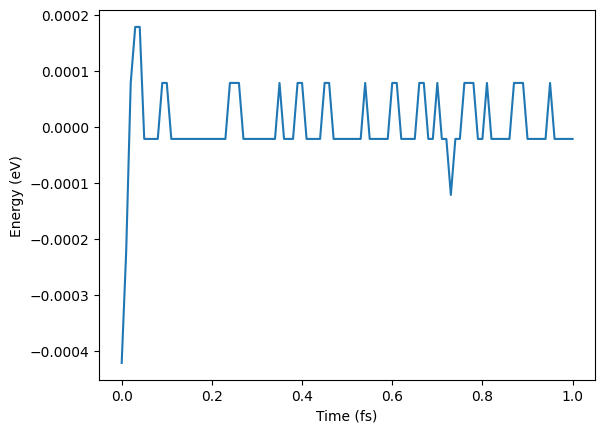

In [10]:
ldopa_dock.run_md_from_xyz()

In [11]:
!ase convert md.traj md.xyz

In [12]:
ud.show_frame("md.xyz", 90)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## scratch

In [37]:
import importlib
importlib.reload(ud)

SyntaxError: unterminated string literal (detected at line 1141) (UMADock.py, line 1141)

## Gradio

In [ ]:
import gradio as gr

In [ ]:
def dock_total(smiles: str, target: str):
  '''

  '''
  test_confs = ud.conformers(smiles,20)
  em_mols = test_confs.get_confs(use_random=True)
  confs = test_confs.prep_XYZ_docking()

  if target == "DRD2":
    ldopa_dock = ud.UMA_Dock(confs, 20, calculator, ud.DRD2_data)

  elif target == "HMGCR":
    ldopa_dock = ud.UMA_Dock(confs, 20, calculator, ud.HMGCR_data)

  elif target == "MAOB":
    ldopa_dock = ud.UMA_Dock(confs, 20, calculator, ud.MAOB_data)

  elif target == "ADRB2":
    ldopa_dock = ud.UMA_Dock(confs, 20, calculator, ud.ADRB2_data)

  new_molecules, ies, distances = ldopa_dock.dock()
  ies, ebes = ldopa_dock.post_process(criteria='distance')

  best_conf_idx = np.argmin(ebes)
  best_energy = ebes[best_conf_idx]

  best_pose_idx = np.argmin(distances[best_conf_idx])

  out_text = f"The lowest elecronic binding energy came from conformer {best_conf_idx}, \
  and pose {best_pose_idx} = {best_energy:.3f} kcal/mol"

  return out_text

In [ ]:
gradio_app = gr.Interface(
    dock_total,
    inputs=[gr.Textbox(label="SMILES to calculate"), gr.Textbox(label="Protein to dock with")],
    outputs=[gr.Textbox(label="Docking Results: ")],
    title="Dock a molecule with UMADock",
)

gradio_app.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://132075be3162a9a635.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
